# Causal Inference

In [1]:
#Installing libraries and packages

In [2]:
pip install dowhy

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge dowhy

Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Nupur\anaconda3


  added / updated specs:
    - dowhy


The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py38haa95532_0 --> conda-forge::conda-4.9.2-py38haa244fe_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [4]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
import dowhy.api
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [45]:
clv = pd.read_csv('data_insy695.csv')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [46]:
clv_clean = clv.drop(columns=["Customer","Effective To Date","Policy Type"])

In [47]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,...,32,5,0,1,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,...,13,42,0,8,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,...,18,38,0,2,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,...,18,65,0,7,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,...,12,44,0,1,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [48]:
clv.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Customer             9134
State                   5
Response                2
Coverage                3
Education               5
Effective To Date      59
EmploymentStatus        5
Gender                  2
Location Code           3
Marital Status          3
Policy Type             3
Policy                  9
Renew Offer Type        4
Sales Channel           4
Vehicle Class           6
Vehicle Size            3
dtype: int64

In [49]:
#Splitting Features into binary and remaining categorical

binary_feature = clv_clean.nunique()[clv_clean.nunique() == 2].keys().tolist()

In [50]:
categorical_feature = [col for col in clv_clean.select_dtypes('object').columns.to_list() if col not in binary_feature]

In [51]:
categorical_feature

['State',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Location Code',
 'Marital Status',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size']

In [52]:
# Feature Engineering  - dummyfying the binary and categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in binary_feature:
    clv_clean[i] = le.fit_transform(clv_clean[i])

In [53]:
clv_clean.columns

Index(['State', 'Customer Lifetime Value', 'Response', 'Coverage', 'Education',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy', 'Renew Offer Type', 'Sales Channel',
       'Total Claim Amount', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [ ]:
clv_clean = clv_clean.rename({'Monthly Premium Auto': 'Monthly_Premium_Auto', 'Total Claim Amount':'Total_Claim_Amount', 'Number of Policies': 'Number_of_Policies', 'Number of Open Complaints': 'Number_of_Open_Complaints'}, axis=1) 


In [54]:
clv_clean.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,0,Basic,Bachelor,Employed,0,56274,Suburban,Married,...,32,5,0,1,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,0,Extended,Bachelor,Unemployed,0,0,Suburban,Single,...,13,42,0,8,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,0,Premium,Bachelor,Employed,0,48767,Suburban,Married,...,18,38,0,2,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,0,Basic,Bachelor,Unemployed,1,0,Suburban,Married,...,18,65,0,7,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,0,Basic,Bachelor,Employed,1,43836,Rural,Single,...,12,44,0,1,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# Treatments

For our causality analysis we will be looking at the effect of three chosen treatments on outcome variables thata are response and customer lifetime value. 
The three treatments are: 
- Employment Status - Retired or not 
- Coverage 
- If they reniewed offer 2 (most popular one)
- If their income is above average or not 

From our analysis of the dataset, we assumed that there are variables that are more likely to have a causal affect on our outcome variables: Customer Lifetime Value and Response. We can see the following variables represented on the graph below...

In [113]:
causal_graph = """digraph {
Income -> Response;
EmploymentStatus -> Income
Monthly_Premium_Auto -> Response;
Number_of_Open_Complaints -> Response;
Total_Claim_Amount -> Response;
Coverage -> Response; 
EmploymentStatus -> Response;
Number_of_Policies -> Response;
Gender -> Response
}"""

## Employment Status 

In [114]:
clv_clean['EmploymentStatus'] = clv_clean['EmploymentStatus'].apply(lambda x: 1 if x=='Retired' else 0)
clv_clean['EmploymentStatus'] = clv_clean['EmploymentStatus'].apply(bool)

### Outcome = Response 

In [115]:
clv_clean['Response'] = clv_clean['Response'].apply(bool)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['EmploymentStatus'] on outcome ['Response']


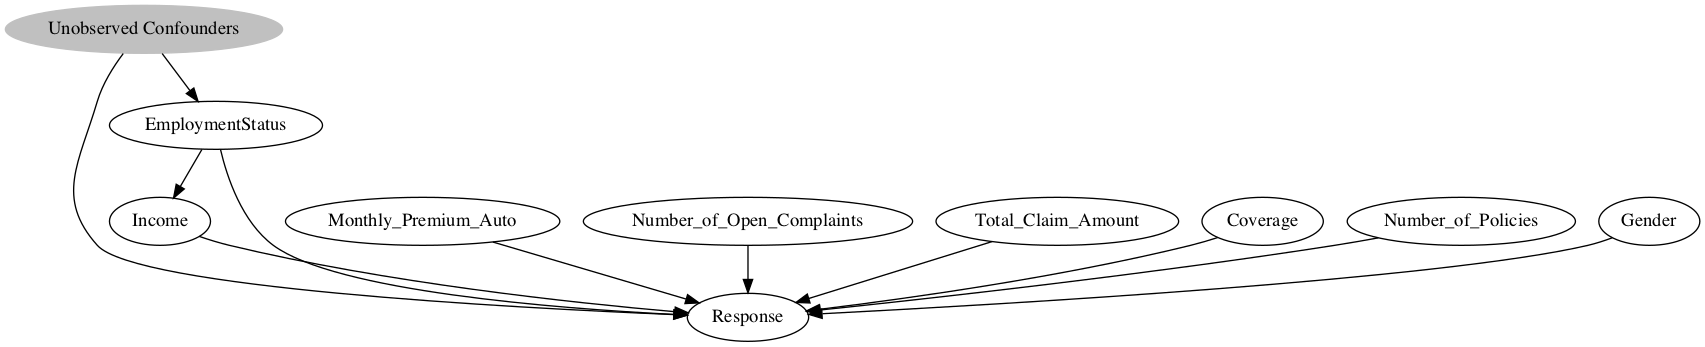

In [116]:
model4= CausalModel(
        data=clv_clean,
        treatment='EmploymentStatus',
        outcome="Response",
         graph = causal_graph.replace("\n", " "),
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model4.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [112]:
identified_estimand4 = model4.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand4)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Response|Number_of_Policies,Monthly_Premium_Au
d[EmploymentStatus]                                                           

                                                                 
to,Gender,Number_of_Open_Complaints,Total_Claim_Amount,Coverage))
                                                                 
Estimand assumption 1, Unconfoundedness: If U→{EmploymentStatus} and U→Response then P(Response|EmploymentStatus,Number_of_Policies,Monthly_Premium_Auto,Gender,Number_of_Open_Complaints,Total_Claim_Amount,Coverage,U) = P(Response|EmploymentStatus,Number_of_Policies,Monthly_Premium_Auto,Gender,Number_of_Open_Complaints,Total_Claim_Amount,Coverage)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
         d                                  

In [90]:
causal_estimate4 = model4.estimate_effect(identified_estimand3,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate4)
print("Causal Estimate is " + str(causal_estimate4.value))

INFO:dowhy.causal_estimator:b: Response~Renew Offer Type+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Total Claim Amount+Coverage+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Renew Offer Type+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Total Claim Amount+Coverage+Number of Policies
Target units: ate

## Estimate
Mean value: 0.30227239707480014
p-value: [2.05802192e-185]

Causal Estimate is 0.30227239707480014


From our result we could inder that if a customer is retired, the odds of them saying yes to a renewal offer goes up by 30%. However, the p-value of more than 0.001 i.e. 0.302 tells us that there is no causal relationship between the treatment and the outcome.

### Outcome = CLV

In [91]:
model41= CausalModel(
        data=clv_clean,
        treatment='EmploymentStatus',
        outcome="Customer Lifetime Value",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model41.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['EmploymentStatus'] on outcome ['Customer Lifetime Value']


In [92]:
identified_estimand41 = model41.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand3)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Response|Monthly Premium Auto,Income,Employmen
d[Renew Offer Type]                                                           

                                                                              
tStatus,Gender,Vehicle Size,Number of Open Complaints,Total Claim Amount,Cover
                                                                              

                        
age,Number of Policies))
                        
Estimand assumption 1, Unconfoundedness: If U→{Renew Offer Type} and U→Response then P(Response|Renew Offer Type,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Total Claim Amount,Coverage,Number of Policies,U) = P(Response|Renew Offer Type,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicl

In [94]:
causal_estimate41 = model41.estimate_effect(identified_estimand41,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate41)
print("Causal Estimate is " + str(causal_estimate41.value))

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~EmploymentStatus+Monthly Premium Auto+Income+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Coverage+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Customer Lifetime Value~EmploymentStatus+Monthly Premium Auto+Income+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Coverage+Number of Policies
Target units: ate

## Estimate
Mean value: -231.5672853316355
p-value: [0.54563766]

Causal Estimate is -231.5672853316355


The p-value of more than 0.001 i.e. 0.5456 tells us that there is no causal relaationship between the treatment and the outcome.



## Renewed most popular offer (offer 2)

In [58]:
clv_clean['Renew Offer Type'] = clv_clean['Renew Offer Type'].apply(lambda x: 1 if x=='Offer2' else 0)
clv_clean['Renew Offer Type'] = clv_clean['Renew Offer Type'].apply(bool)

### Outcome = Response 

In [80]:
model3= CausalModel(
        data=clv_clean,
        treatment='Renew Offer Type',
        outcome="Response",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model3.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Renew Offer Type'] on outcome ['Response']


In [81]:
identified_estimand3 = model3.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand3)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Response|Monthly Premium Auto,Income,Employmen
d[Renew Offer Type]                                                           

                                                                              
tStatus,Gender,Vehicle Size,Number of Open Complaints,Total Claim Amount,Cover
                                                                              

                        
age,Number of Policies))
                        
Estimand assumption 1, Unconfoundedness: If U→{Renew Offer Type} and U→Response then P(Response|Renew Offer Type,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Total Claim Amount,Coverage,Number of Policies,U) = P(Response|Renew Offer Type,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicl

In [82]:
causal_estimate3 = model3.estimate_effect(identified_estimand3,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate3)
print("Causal Estimate is " + str(causal_estimate3.value))

INFO:dowhy.causal_estimator:b: Response~Renew Offer Type+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Total Claim Amount+Coverage+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Renew Offer Type+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Total Claim Amount+Coverage+Number of Policies
Target units: ate

## Estimate
Mean value: 0.13577096960840376
p-value: [1.91191812e-72]

Causal Estimate is 0.13577096960840376


The p-value < 0.001 i.e. 1.91191812e-72 tells us that **there is a causal relaationship** between the treatment and the outcome. If the customer renews the most popular offer (aka offer 2), the odds of them responding yes to the renewal increases by 13.58%. 



### Outcome = CLV

In [83]:
model31= CausalModel(
        data=clv_clean,
        treatment='Renew Offer Type',
        outcome="Customer Lifetime Value",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model31.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Renew Offer Type'] on outcome ['Customer Lifetime Value']


In [84]:
identified_estimand31 = model31.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand31)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Customer Lifetime Value|Monthly Premium Auto,I
d[Renew Offer Type]                                                           

                                                                              
ncome,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Total Cla
                                                                              

                                       
im Amount,Coverage,Number of Policies))
                                       
Estimand assumption 1, Unconfoundedness: If U→{Renew Offer Type} and U→Customer Lifetime Value then P(Customer Lifetime Value|Renew Offer Type,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Total Claim Amount,Coverage,Number of Policies,U) = P(Customer 

In [86]:
causal_estimate31 = model31.estimate_effect(identified_estimand31,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate31)
print("Causal Estimate is " + str(causal_estimate31.value))

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~Renew Offer Type+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Total Claim Amount+Coverage+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Customer Lifetime Value~Renew Offer Type+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Total Claim Amount+Coverage+Number of Policies
Target units: ate

## Estimate
Mean value: -600.8904175778762
p-value: [2.79475762e-05]

Causal Estimate is -600.8904175778762


The p-value < 0.001 i.e. 2.79475762e-05 tells us that **there is a causal relationship** between the treatment and the outcome. If the customer renews the most popular offer (aka offer 2), the CLV is more likely to decrease on average by $600.



## Coverage (Premium or not)

In [59]:
clv_clean['Coverage'] = clv_clean['Coverage'].apply(lambda x: 1 if x=='Premium' else 0)
clv_clean['Coverage'] = clv_clean['Coverage'].apply(bool)

### Outcome = Response

In [71]:
model11= CausalModel(
        data=clv_clean,
        treatment='Coverage',
        outcome="Response",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model11.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Coverage'] on outcome ['Response']


In [72]:
identified_estimand11 = model11.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand11)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                                        
───────────(Expectation(Response|Monthly Premium Auto,Income,EmploymentStatus,
d[Coverage]                                                                   

                                                                              
Gender,Vehicle Size,Number of Open Complaints,Renew Offer Type,Total Claim Amo
                                                                              

                        
unt,Number of Policies))
                        
Estimand assumption 1, Unconfoundedness: If U→{Coverage} and U→Response then P(Response|Coverage,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Offer Type,Total Claim Amount,Number of Policies,U) = P(Response|Coverage,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of

In [73]:
causal_estimate11 = model11.estimate_effect(identified_estimand11,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate11)
print("Causal Estimate is " + str(causal_estimate11.value))

INFO:dowhy.causal_estimator:b: Response~Coverage+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Coverage+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Number of Policies
Target units: ate

## Estimate
Mean value: 0.011638509408402331
p-value: [0.36693648]

Causal Estimate is 0.011638509408402331


### Outcome = CLV

In [77]:
model12= CausalModel(
        data=clv_clean,
        treatment='Coverage',
        outcome="Customer Lifetime Value",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model12.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Coverage'] on outcome ['Customer Lifetime Value']


In [78]:
identified_estimand12 = model12.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand12)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                                        
───────────(Expectation(Customer Lifetime Value|Monthly Premium Auto,Income,Em
d[Coverage]                                                                   

                                                                              
ploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Offer Type,
                                                                              

                                       
Total Claim Amount,Number of Policies))
                                       
Estimand assumption 1, Unconfoundedness: If U→{Coverage} and U→Customer Lifetime Value then P(Customer Lifetime Value|Coverage,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Offer Type,Total Claim Amount,Number of Policies,U) = P(Customer Lifetime

In [79]:
causal_estimate12 = model12.estimate_effect(identified_estimand12,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate12)
print("Causal Estimate is " + str(causal_estimate12.value))

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~Coverage+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Customer Lifetime Value~Coverage+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Number of Policies
Target units: ate

## Estimate
Mean value: -406.5270155918706
p-value: [0.1003263]

Causal Estimate is -406.5270155918706


## Income (True if above average)

In [64]:
avg_income = clv_clean['Income'].mean()
clv_clean['Above_Avg_Income']  = clv_clean['Income'] > avg_income
clv_clean['Above_Avg_Income'] = clv_clean['Above_Avg_Income'].apply(bool)


### Outcome = Response 

In [65]:
model2= CausalModel(
        data=clv_clean,
        treatment='Above_Avg_Income',
        outcome="Response",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model2.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Above_Avg_Income'] on outcome ['Response']


In [66]:
identified_estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand2)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Response|Monthly Premium Auto,Income,Employmen
d[Above_Avg_Income]                                                           

                                                                              
tStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Offer Type,Total C
                                                                              

                                         
laim Amount,Coverage,Number of Policies))
                                         
Estimand assumption 1, Unconfoundedness: If U→{Above_Avg_Income} and U→Response then P(Response|Above_Avg_Income,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Offer Type,Total Claim Amount,Coverage,Number of Policies,U) = P(Response|Above_A

In [67]:
causal_estimate2 = model2.estimate_effect(identified_estimand2,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate2)
print("Causal Estimate is " + str(causal_estimate2.value))

INFO:dowhy.causal_estimator:b: Response~Above_Avg_Income+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Coverage+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Response~Above_Avg_Income+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Coverage+Number of Policies
Target units: ate

## Estimate
Mean value: -0.008562524931706894
p-value: [0.53240536]

Causal Estimate is -0.008562524931706894


### Outcome = CLV 

In [68]:
model21= CausalModel(
        data=clv_clean,
        treatment='Above_Avg_Income',
        outcome="Customer Lifetime Value",
        common_causes=['Renew Offer Type','Monthly Premium Auto','Number of Open Complaints','Total Claim Amount','Coverage','EmploymentStatus',
                      'Gender','Vehicle Size','Number of Policies', 'Income'])
model21.view_model()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Above_Avg_Income'] on outcome ['Customer Lifetime Value']


In [69]:
identified_estimand21 = model21.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand21)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
         d                                                                    
───────────────────(Expectation(Customer Lifetime Value|Monthly Premium Auto,I
d[Above_Avg_Income]                                                           

                                                                              
ncome,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Off
                                                                              

                                                        
er Type,Total Claim Amount,Coverage,Number of Policies))
                                                        
Estimand assumption 1, Unconfoundedness: If U→{Above_Avg_Income} and U→Customer Lifetime Value then P(Customer Lifetime Value|Above_Avg_Income,Monthly Premium Auto,Income,EmploymentStatus,Gender,Vehicle Size,Number of Open Complaints,Renew Offer 

In [70]:
causal_estimate21 = model21.estimate_effect(identified_estimand21,
        method_name="backdoor.linear_regression",test_significance=True)
print(causal_estimate21)
print("Causal Estimate is " + str(causal_estimate21.value))

INFO:dowhy.causal_estimator:b: Customer Lifetime Value~Above_Avg_Income+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Coverage+Number of Policies
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: Customer Lifetime Value~Above_Avg_Income+Monthly Premium Auto+Income+EmploymentStatus+Gender+Vehicle Size+Number of Open Complaints+Renew Offer Type+Total Claim Amount+Coverage+Number of Policies
Target units: ate

## Estimate
Mean value: -240.84619017280875
p-value: [0.35978577]

Causal Estimate is -240.84619017280875


In [23]:
#We might wanna check for gender >>> heterogenous effect 